In [1]:
# this is the python script for allocating heat pumps to MV loads
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import json
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
# outlier filtering
def outlier_filtering(df, column, quantile=0.95):
    quantile_value = df[column].quantile(quantile)
    df = df[df[column] < quantile_value]
    return df, quantile_value

1. Filter out HP by rated power \
input: original HP data \
output: filtered HP data

In [8]:
# load the data
script_path = os.getcwd()
data_path = os.path.join(script_path, 'Buildings_data')
HP = pd.read_csv(os.path.join(data_path, 'Buildings_data_new.csv')) 

In [9]:
HP_filtered, quantile_value = outlier_filtering(HP, 'PRT', quantile=0.95)
HP_filtered.to_csv(os.path.join(data_path, 'Buildings_data_filtered.csv'), index=False)

In [10]:
filtered_rated = 1- len(HP_filtered)/len(HP)
print('The percentage of filtered buildings is: ', filtered_rated)

The percentage of filtered buildings is:  0.050000065952706674


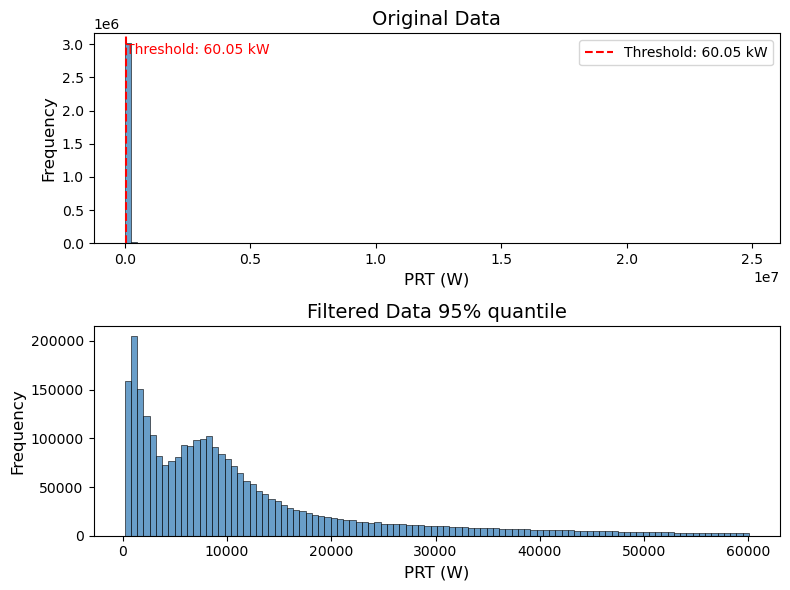

In [15]:
# Set up the figure
colors = sns.color_palette('Set1')
plt.figure(figsize=(8, 6))

# Plot 1: Histogram of original data
plt.subplot(2, 1, 1)
sns.histplot(HP['PRT'], bins=100, kde=False, color=colors[1], edgecolor='black')
plt.axvline(quantile_value, color='red', linestyle='--', label=f'Threshold: {quantile_value / 1000:.2f} kW')
plt.text(quantile_value, plt.gca().get_ylim()[1] * 0.9, 
         f"Threshold: {quantile_value / 1000:.2f} kW", 
         color='red', ha='left', fontsize=10)
plt.xlabel('PRT (W)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Original Data', fontsize=14)
plt.legend()

# Plot 2: Histogram of filtered data
plt.subplot(2, 1, 2)
sns.histplot(HP_filtered['PRT'], bins=100, kde=False, color=colors[1], edgecolor='black')
plt.xlabel('PRT (W)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Filtered Data 95% quantile', fontsize=14)

plt.tight_layout()
plt.savefig('PRT_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


send HP_filtered to euler, split the HP_filter by municipality, check if there is repeted allocation of HP to different municipalities, and do the parallel allocation of HP_filter to LV nodes. Get the result and do the analysis below:\
input: HP_filtered\
output: HP_filtered_LV

In [16]:
LV_processed = pd.read_csv('HP_allocation_LV/Building_allocation_LV.csv')

In [8]:
def data_aggregate(building_data_part):
    building_copy = building_data_part.copy()
    building_copy = building_copy.drop(columns=['GKODN', 'GKODE', 'ISHP', 'geometry', 'EGID'])
    # Get the most frequent T_PROFILE for each LV_grid and LV_osmid
    most_frequent_T_profile = (
        building_copy.groupby(['LV_grid', 'LV_osmid'])['T_PROFILE']
        .agg(lambda x: x.mode()[0])
    )
    # Aggregate other building data by summing numerical columns
    building_data_0 = (
        building_copy.drop(columns=['GEBF', 'GAREA'])
        .groupby(['LV_grid', 'LV_osmid'], as_index=False)
        .sum())
    # Map the most frequent T_PROFILE back to the grouped data
    building_data_0 = building_data_0.set_index(['LV_grid', 'LV_osmid'])
    building_data_0['T_PROFILE'] = most_frequent_T_profile
    building_data_0 = building_data_0.reset_index()

    # Convert PRT and HBLD to kW
    building_data_0['PRT'] = building_data_0['PRT'] / 10**3  # Convert PRT to kW
    building_data_0['HBLD'] = building_data_0['HBLD'] / 10**3  # Convert HBLD to kW/K
    
    # Rename columns for clarity
    building_data_0.rename(columns={
        'PRT': 'PRT_kW',
        'CBLD': 'CBLD_KWh/K',
        'HBLD': 'HBLD_kW/K'
    }, inplace=True)
    
    return building_data_0


In [9]:
LV_by_grid = data_aggregate(LV_processed)
LV_by_grid = LV_by_grid[(LV_by_grid['LV_grid']!='-1')&(LV_by_grid['LV_osmid']!=-1)]

In [10]:
LV_by_grid.head()

,LV_grid,LV_osmid,HBLD_kW/K,CBLD_KWh/K,PRT_kW,T_PROFILE
0,1-1_0_7,0.0,1.121875,60.750000,51.030000,NABZUE
1,1-1_0_7,1.0,0.878725,47.583333,25.179459,NABZUE
2,1-1_0_7,3.0,0.203138,11.000000,5.433419,NABZUE
3,1-1_0_7,6.0,0.475527,25.750000,13.071429,NABZUE
4,1-1_0_7,7.0,0.260078,14.083333,11.830000,NABZUE


In [13]:
LV_filtered, outlier_threshold = outlier_filtering(LV_by_grid, 'PRT_kW', quantile=0.95)

In [14]:
# find the LV_grid and LV_osmid pair that should be filtered out
filtered_pair = LV_by_grid[~LV_by_grid.index.isin(LV_filtered.index)][['LV_grid', 'LV_osmid']]
filtered_pair = filtered_pair.drop_duplicates()
filtered_pair.head()

,LV_grid,LV_osmid
0,1-1_0_7,0.0
44,1-1_0_7,76.0
211,1-2_1_5,88.0
224,1-2_1_5,105.0
233,1-2_1_5,121.0


In [15]:
LV_filtered.groupby('LV_grid')['PRT_kW'].sum().sort_values(ascending=False).describe()

count    33753.000000
mean       654.304394
std        550.208440
min          0.350000
25%        237.618089
50%        511.743164
75%        922.832023
max       4223.397012
Name: PRT_kW, dtype: float64

In [19]:
# open data_processing/file_folder_lv.json
with open (r'C:\Users\14914\Desktop\lectures\SwissPDGs-TimeSeries\data_processing\file_folder_lv.json') as f:
    lv_folder = json.load(f)
save_path = script_path+'/HP_allocation_LV'
unique_LV = LV_filtered['LV_grid'].unique()
for LV_grid in unique_LV:
    grid_save_path = save_path+'/'+lv_folder[LV_grid]
    if not os.path.exists(grid_save_path):
        os.makedirs(grid_save_path)
    file_LV = LV_filtered[LV_filtered['LV_grid']==LV_grid]  
    file_LV.to_csv(grid_save_path+'/'+LV_grid+'_HP.csv', index=False)

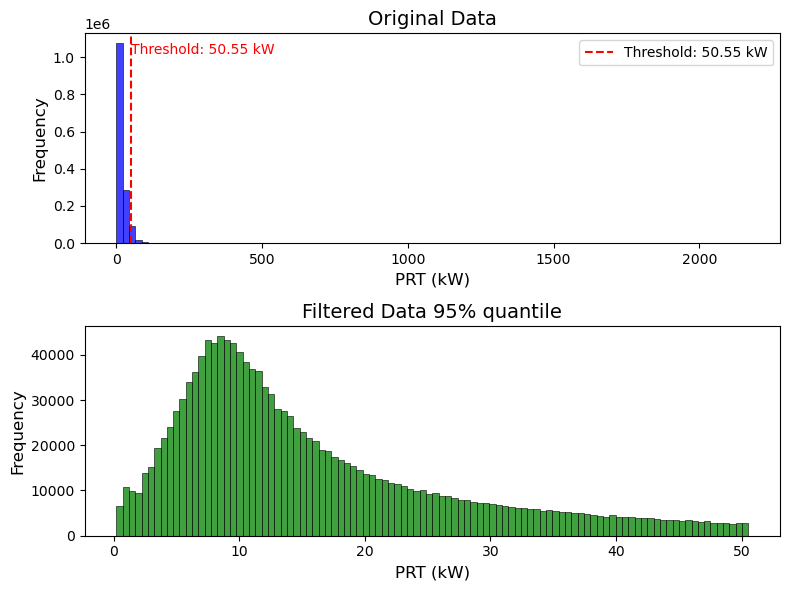

In [20]:
# Set up the figure
plt.figure(figsize=(8, 6))

# Plot 1: Histogram of original data
plt.subplot(2, 1, 1)
sns.histplot(LV_by_grid['PRT_kW'], bins=100, kde=False, color='blue', edgecolor='black')
plt.axvline(outlier_threshold, color='red', linestyle='--', label=f'Threshold: {outlier_threshold:.2f} kW')
plt.text(outlier_threshold, plt.gca().get_ylim()[1] * 0.9, 
         f"Threshold: {outlier_threshold:.2f} kW", 
         color='red', ha='left', fontsize=10)
plt.xlabel('PRT (kW)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Original Data', fontsize=14)
plt.legend()

# Plot 2: Histogram of filtered data
plt.subplot(2, 1, 2)
sns.histplot(LV_filtered['PRT_kW'], bins=100, kde=False, color='green', edgecolor='black')
plt.xlabel('PRT (kW)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Filtered Data 95% quantile', fontsize=14)

plt.tight_layout()
plt.show()

prepare buildings for MV grid

In [21]:
building_data_origin = HP

In [22]:
pairs = [tuple(row) for row in filtered_pair[['LV_grid', 'LV_osmid']].values]
processed = LV_processed[
    ~LV_processed[['LV_grid', 'LV_osmid']].apply(tuple, axis=1).isin(pairs)]

In [23]:
# Extract matched rows
matched_rows_df = building_data_origin[
    building_data_origin['EGID'].isin(processed[processed['LV_grid'] != '-1']['EGID'])
]
# Extract unmatched rows
unmatched_rows_df = building_data_origin[
    ~building_data_origin['EGID'].isin(processed[processed['LV_grid'] != '-1']['EGID'])
]
a=len(matched_rows_df)/len(building_data_origin)
b=len(unmatched_rows_df)/len(building_data_origin)
c=a+b
# Verify counts
print(f"Matched rows: {a}")
print(f"Unmatched rows: {b}")
print(f"Total: {c}")


Matched rows: 0.690715771534548
Unmatched rows: 0.309284228465452
Total: 1.0


In [24]:
MV_filtered, outlier_threshold = outlier_filtering(unmatched_rows_df, 'PRT', quantile=0.95)
MV_filtered.to_csv('Buildings_data/Buildings_data_MV_filtered.csv', index=False)

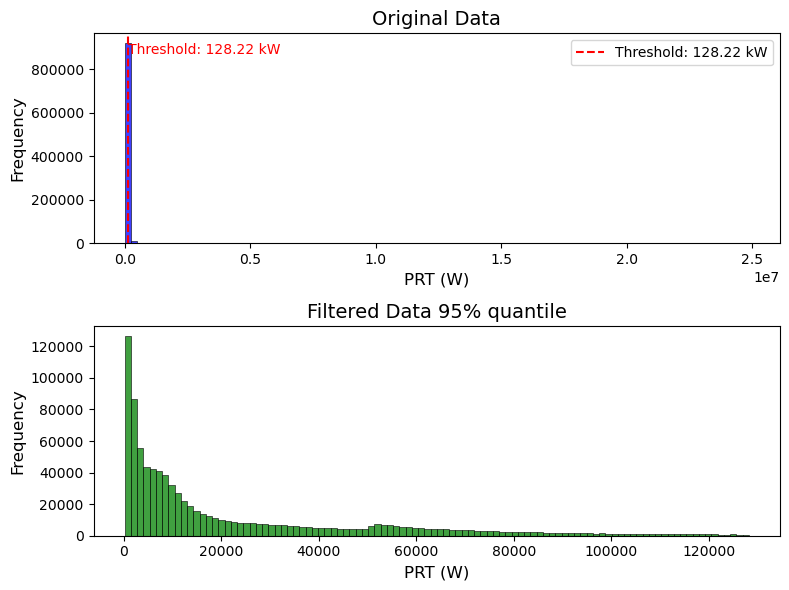

In [25]:
# Set up the figure
plt.figure(figsize=(8, 6))

# Plot 1: Histogram of original data
plt.subplot(2, 1, 1)
sns.histplot(unmatched_rows_df['PRT'], bins=100, kde=False, color='blue', edgecolor='black')
plt.axvline(outlier_threshold, color='red', linestyle='--', label=f'Threshold: {outlier_threshold / 1000:.2f} kW')
plt.text(outlier_threshold, plt.gca().get_ylim()[1] * 0.9, 
         f"Threshold: {outlier_threshold / 1000:.2f} kW", 
         color='red', ha='left', fontsize=10)
plt.xlabel('PRT (W)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Original Data', fontsize=14)
plt.legend()

# Plot 2: Histogram of filtered data
plt.subplot(2, 1, 2)
sns.histplot(MV_filtered['PRT'], bins=100, kde=False, color='green', edgecolor='black')
plt.xlabel('PRT (W)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Filtered Data 95% quantile', fontsize=14)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Import allocation results of MV

In [26]:
def data_aggregate_mv(building_data_part):
    building_copy = building_data_part.copy()
    building_copy = building_copy.drop(columns=['GKODN', 'GKODE', 'ISHP', 'geometry', 'EGID'])
    
    # Get the most frequent T_PROFILE for each LV_grid and LV_osmid
    most_frequent_T_profile = (
        building_copy.groupby(['MV_grid', 'MV_osmid'])['T_PROFILE']
        .agg(lambda x: x.mode()[0])
    )
    
    # Aggregate other building data by summing numerical columns
    building_data_0 = (
        building_copy.drop(columns=['GEBF', 'GAREA'])
        .groupby(['MV_grid', 'MV_osmid'], as_index=False)
        .sum()
    )
    
    # Map the most frequent T_PROFILE back to the grouped data
    building_data_0 = building_data_0.set_index(['MV_grid', 'MV_osmid'])
    building_data_0['T_PROFILE'] = most_frequent_T_profile
    building_data_0 = building_data_0.reset_index()

    # Convert PRT and HBLD to kW
    building_data_0['PRT'] = building_data_0['PRT'] / 10**3  # Convert PRT to kW
    building_data_0['HBLD'] = building_data_0['HBLD'] / 10**3  # Convert HBLD to kW/K
    
    # Rename columns for clarity
    building_data_0.rename(columns={
        'PRT': 'PRT_kW',
        'CBLD': 'CBLD_KWh/K',
        'HBLD': 'HBLD_kW/K'
    }, inplace=True)
    
    return building_data_0

In [27]:
MV_processed = pd.read_csv('Buildings_data/Buildings_data_MV_processed.csv')
MV_processed_by_grid = data_aggregate_mv(MV_processed)
MV_processed_by_grid = MV_processed_by_grid[(MV_processed_by_grid['MV_grid']!='-1')&(MV_processed_by_grid['MV_osmid']!=-1)]

In [28]:
MV_processed_by_grid.head()

,MV_grid,MV_osmid,HBLD_kW/K,CBLD_KWh/K,PRT_kW,T_PROFILE
1,0_0,0.0,245.768185,14719.000000,7744.637091,INNEBI
2,0_0,3.0,21.987291,1193.500000,747.078610,INNEBI
3,0_0,6.0,4.549794,238.083333,181.591527,INNEBI
4,0_0,7.0,6.860824,352.500000,296.100000,INNEBI
5,0_0,9.0,29.722454,1716.833333,885.818341,INNEBI


In [29]:
MV_processed_filtered, outlier_threshold = outlier_filtering(MV_processed_by_grid, 'PRT_kW', quantile=0.95)
filtered_pair = MV_processed_by_grid[~MV_processed_by_grid.index.isin(MV_processed_filtered.index)][['MV_grid', 'MV_osmid']]
filtered_pair = filtered_pair.drop_duplicates()
pairs_mv = [tuple(row) for row in filtered_pair[['MV_grid', 'MV_osmid']].values]
processed_mv = MV_processed[
    ~MV_processed[['MV_grid', 'MV_osmid']].apply(tuple, axis=1).isin(pairs_mv)
]

In [36]:
MV_save_path = script_path+'/HP_allocation_MV'
if not os.path.exists(grid_save_path):
        os.makedirs(grid_save_path)
unique_MV = MV_processed_filtered['MV_grid'].unique()
for MV_grid in unique_MV:
    grid_save_path = MV_save_path
    file_MV = MV_processed_filtered[MV_processed_filtered['MV_grid']==MV_grid]  
    file_MV.to_csv(grid_save_path+'/'+MV_grid+'_HP.csv', index=False)

In [31]:
processed_mv.to_csv('Buildings_data/Buildings_data_MV_processed_filtered.csv', index=False)

In [32]:
print("The percentage of filtered allocations of MV loads is: ", 1- len(processed_mv)/len(MV_processed))

The percentage of filtered allocations of MV loads is:  0.32154136578818004


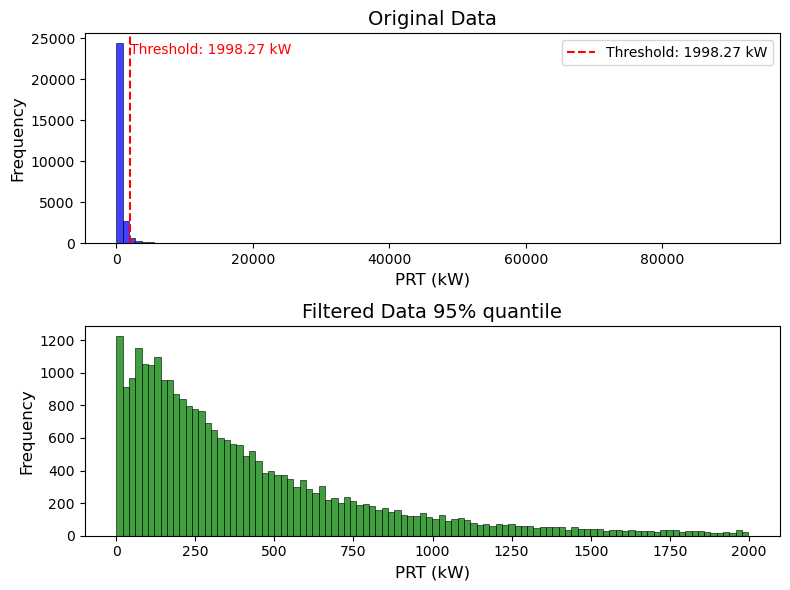

In [33]:
# figure
plt.figure(figsize=(8, 6))

# Plot 1: Histogram of original data
plt.subplot(2, 1, 1)
sns.histplot(MV_processed_by_grid['PRT_kW'], bins=100, kde=False, color='blue', edgecolor='black')
plt.axvline(outlier_threshold, color='red', linestyle='--', label=f'Threshold: {outlier_threshold:.2f} kW')
plt.text(outlier_threshold, plt.gca().get_ylim()[1] * 0.9, 
         f"Threshold: {outlier_threshold:.2f} kW", 
         color='red', ha='left', fontsize=10)
plt.xlabel('PRT (kW)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Original Data', fontsize=14)
plt.legend()

# Plot 2: Histogram of filtered data
plt.subplot(2, 1, 2)
sns.histplot(MV_processed_filtered['PRT_kW'], bins=100, kde=False, color='green', edgecolor='black')
plt.xlabel('PRT (kW)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Filtered Data 95% quantile', fontsize=14)

plt.tight_layout()
plt.show()
